In [1]:
import pandas as pd
import numpy as np
import os

In [8]:
df = pd.read_csv('data/consolidated_articles_v2.csv')

In [5]:
df.head()

,Unnamed: 0,Extracted Article,Bias
0,0,U.S. cyber operators disrupted internet access...,-5.33
1,1,A federal appeals court rejected the most dire...,0.67
2,2,"U.S Senator Elizabeth Warren, who is competing...",-10.00
3,3,announced Tuesday that it will block landlords...,-2.33
4,4,"President Donald Trump and ""the Trump of the T...",-4.33


In [10]:
import nltk
#nltk.download('stopwords')
from text_utils.text_processing import process_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TanushPasupuleti\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [15]:
import nltk
#nltk.download('punkt')
#nltk.download('wordnet')

df['Processed Sentence'] = df['Extracted Article'].apply(lambda x: process_text(x))

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135322 entries, 0 to 135321
Data columns (total 4 columns):
Unnamed: 0            135322 non-null int64
Extracted Article     135322 non-null object
Bias                  135322 non-null float64
Processed Sentence    135322 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 4.1+ MB


In [17]:
df['Processed Sentence'].iloc[10]

'handful democratic candidate president released least 10 year federal tax return effort promote transparency create contrast president donald trump s refused release return candidate president interested 2020 election add 2020 election interest stay date latest 2020 election news video analysis abc news add interest notable takeaway new financial data sen bernie sander vermont kamala harris california elizabeth warren massachusetts kirsten gillibrand new york amy klobuchar minnesota washington gov jay inslee former texas rep beto o rourke re earning one apparent takeaway candidate tax document much re making year candidate reported making 200 000 filed jointly spouse adjusted gross income 2018 putting substantially average american s earnings ranging harris 1 9 million warren 846 394 inslee 202 912 seven 2020 candidate release return least three millionaire sander warren harris sander famous campaign unjust power richest 1 reported adjusted gross income 1 06 million 2016 1 13 million 

In [21]:
def allocate_bias_sentiment(bias):
    if (bias>=0):
        return 'positive bias'
    elif (bias<0):
        return 'negative bias'
    else:
        return 'no bias'

In [22]:
df['Bias Sentiment'] = df['Bias'].map(lambda x: allocate_bias_sentiment(x))

In [23]:
df['Bias Sentiment'].value_counts()

negative bias    73572
positive bias    61750
Name: Bias Sentiment, dtype: int64

In [42]:
class_weight = { 0: 1,
                1: 1.20}

### LSTM Modeling
1. Vectorize consumer complaints text, by turning each text into either a sequence of integers or into a vector.
2. Limit the data set to the top 5,0000 words.

3. Set the max number of words in each complaint at 250.

In [29]:
#!pip install keras
#!pip install tensorflow

In [30]:
from keras.preprocessing.text import Tokenizer
import warnings
warnings.filterwarnings('ignore')

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Processed Sentence'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 280954 unique tokens.


In [31]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

Truncate and pad the input sequences so that they are all in the same length for modeling.

In [32]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df['Processed Sentence'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (135322, 250)


Converting categorical labels to numbers.

In [33]:
Y = pd.get_dummies(df['Bias Sentiment']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (135322, 2)


Train test split.

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(121789, 250) (121789, 2)
(13533, 250) (13533, 2)


1. The first layer is the embedded layer that uses 100 length vectors to represent each word.
2. SpatialDropout1D performs variational dropout in NLP models.
3. The next layer is the LSTM layer with 100 memory units.
4. The output layer must create 13 output values, one for each class.
5. Activation function is softmax for multi-class classification.
6. Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('models/weights_{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________


In [43]:
from keras.callbacks import EarlyStopping

epochs = 1000
batch_size = 64

history = model.fit(X_train, Y_train, class_weight=class_weight, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Train on 109610 samples, validate on 12179 samples
Epoch 1/1000
109610/109610 [==============================] - 960s 9ms/step - loss: 0.5354 - accuracy: 0.7435 - val_loss: 0.4741 - val_accuracy: 0.7863
Epoch 2/1000
109610/109610 [==============================] - 961s 9ms/step - loss: 0.4173 - accuracy: 0.8223 - val_loss: 0.4527 - val_accuracy: 0.8014
Epoch 3/1000
109610/109610 [==============================] - 929s 8ms/step - loss: 0.3499 - accuracy: 0.8563 - val_loss: 0.4261 - val_accuracy: 0.8231
Epoch 4/1000
109610/109610 [==============================] - 931s 8ms/step - loss: 0.2673 - accuracy: 0.8958 - val_loss: 0.4300 - val_accuracy: 0.8309
Epoch 5/1000
109610/109610 [==============================] - 923s 8ms/step - loss: 0.2200 - accuracy: 0.9164 - val_loss: 0.4670 - val_accuracy: 0.8252
Epoch 6/1000
109610/109610 [==============================] - 923s 8ms/step - loss: 0.1546 - accuracy: 0.9452 - val_loss: 0.5253 - val_accuracy: 0.8295
Epoch 7/1000
109610/109610 [=========

In [44]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

13533/13533 [==============================] - 30s 2ms/step
Test set
  Loss: 1.059
  Accuracy: 0.819


In [45]:
import matplotlib.pyplot as plt 

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

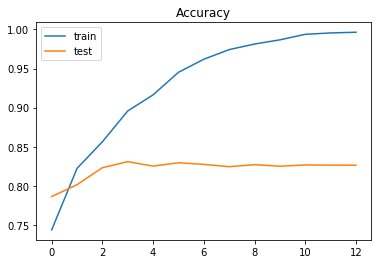

In [46]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

The plots suggest that the model has a little over fitting problem, more data may help, but more epochs will not help using the current data.

In [47]:
new_complaint = ["Trump's policy of immigration is excellent and admirable"]
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)

In [48]:
pred

array([[0.07616071, 0.9238392 ]], dtype=float32)

In [49]:
model.predict_classes(padded)

array([1], dtype=int64)

In [50]:
from keras.models import load_model

model.save('final_model_loss_0.88_acc_0.82.h5')  # creates a HDF5 file 'my_model.h5'

In [51]:
model = load_model('final_model_loss_0.88_acc_0.82.h5')